---
<u><h1>Sentiment Analysis with Naive Bayes and LSTM</h1></u>
---
---

In this notebook, we try to predict the positive (label 1) or negative (label 0) sentiment of the sentence. We use the [UCI Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences). 

Sentiment analysis is very useful in many areas. For example, it can be used for internet conversations moderation. Also, it is possible to predict ratings which users can assign to some product (food, household appliances, hotels, films etc) based on the reviews.

We are using two families of machine learning algorithms in this notebook: Naive Bayes (NB) and long short term memory neural networks (LSTM). You can read more about them here:

* http://blog.aylien.com/naive-bayes-for-dummies-a-simple-explanation/
* https://deeplearning4j.org/lstm.html
* http://colah.github.io/posts/2015-08-Understanding-LSTMs/
* https://arxiv.org/pdf/1412.3555v1.pdf
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Import libraries

We will use pandas, numpy for data manipulation, nltk for natural language processing, matplotlib, seaborn and plotly for data visualization, sklearn and keras for learning the models.

In [569]:
import pandas as pd
import numpy as np
import string, re
import itertools
import nltk
import plotly.offline as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
py.init_notebook_mode(connected=True)
%matplotlib inline

### Load the dataset

First, we need to load the dataset from 3 separate files and concatenate them into 1 dataframe. You can find film reviews using the IMDB service, reviews about different local services using Yelp, and reviews about different goods using Amazon. The text of the reviews we insert in the `Sentence` column and the label with a positive or negative sentiment in the `Sentiment` column.

In [570]:
imdb = pd.read_table('imdb_labelled.txt', header=None, names=['Sentence', 'Sentiment'])
yelp = pd.read_table('yelp_labelled.txt', header=None, names=['Sentence', 'Sentiment'])
amazon = pd.read_table('amazon_cells_labelled.txt', header=None, names=['Sentence', 'Sentiment'])

In [571]:
df = pd.concat([imdb, yelp, amazon])

In [572]:
df.head()

,Sentence,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


### Exploratory Data Analysis

In the next 2 cells we examine the shape of our dataset and check if there are some missing values. We can see that there aren't missing values because the shape of the dataset after removing missing values equals the shape of the dataset before this procedure.

In [573]:
print(df.shape)
print(imdb.shape)
print(yelp.shape)
print(amazon.shape)

(2748, 2)
(748, 2)
(1000, 2)
(1000, 2)


In [574]:
print(df.dropna().shape)

(2748, 2)


In the next cell, we look at the length of all reviews in the `Sentence` column and measure some interesting statistics. Note, that the average length of the review is 72 symbol, but it can deviate by 201 symbols very often. Also, we have some review with more than 7900 symbols. It seems, that there are some very short reviews because the shortest sentence has only 7 symbols and also the standard deviation and the mean points on this.

In [575]:
lens = df['Sentence'].str.len()
print(lens.mean(), lens.std(), lens.min(), lens.max())

71.52838427947599 201.98726634331325 7 7944


Let's also build a histogram which the distribution of the length of the reviews. We can see that most of reviews have the length between 1 and 50 symbols. There are many reviews in the 50-100 symbols range. Almost all reviews have the length less than 300 symbols.

In [576]:
data = [go.Histogram(x=lens, xbins=dict(start=0, end=8000, size=50), marker=dict(color='#8c42f4'))]
layout = go.Layout(
    title='Length of reviews distribution',
    xaxis=dict(
        title='Length'
    ),
    yaxis=dict(
        title='Count'
    ),
    bargap=0.1)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='length histogram')

We can check is there any correlation between the length of the review and the sentiment label. On the 2 graphs below we demonstrate that there are no significant correlations between these variables.

In [577]:
df['senLen'] = df['Sentence'].apply(lambda x: len(x))

In [578]:
data = df.sort_values(by='senLen')
plot = go.Scatter(x = data['senLen'], y = data['Sentiment'], mode='markers')
lyt = go.Layout(title="Review Length vs. Sentiment Label", xaxis=dict(title='Review Length'),yaxis=dict(title='Label'))
fig = go.Figure(data=[plot], layout=lyt)
py.iplot(fig)

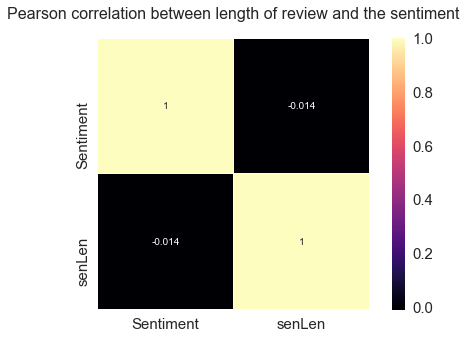

In [579]:
colormap = plt.cm.magma
plt.figure(figsize=(8,5))
plt.title('Pearson correlation between length of review and the sentiment', y=1.05, size=16)
sns.heatmap(data.drop(['Sentence'], axis=1).astype(float).corr(),linewidths=0.01,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)

### Distibution analysis

Now we want to examine the distributions of sentiments. From the histogram below we can see that the dataset is balanced, which is very good in terms of algorithms training. There are approximately 1400 examples in both "0" and "1" categories.

Text(0,0.5,'Count')

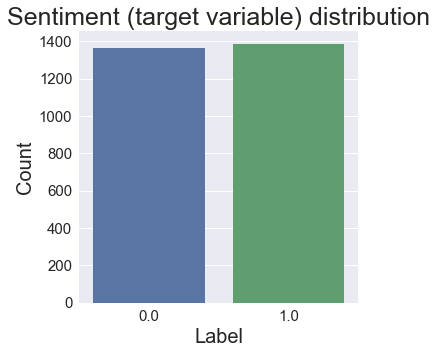

In [580]:
plt.figure(figsize=(5,5))
sns.set(style="darkgrid", font_scale = 1.5)
b = sns.countplot(x='Sentiment', data = df.drop(['Sentence'], axis=1).astype(float))
b.axes.set_title('Sentiment (target variable) distribution',fontsize=25)
b.set_xlabel("Label",fontsize=20)
b.set_ylabel("Count",fontsize=20)

### Text preprocessing

Before we feed our data to the learning algorithms we need to preprocess it. For this dataset, we remove all punctuation signs and transform all letters to the lowercase.

In [581]:
import string, re

def remove_punkt(x):
    comp = re.compile("[%s\d]" % re.escape(string.punctuation))
    return " ".join(comp.sub(" ", str(x)).split())

df['Sentence'] = df['Sentence'].apply(remove_punkt)
df['Sentence'] = df['Sentence'].apply(lambda x: x.lower())

Now we split the dataset into features (X) and target variable (y). In the second cell, we split the dataset into train and test set. The size of the test set is 10%. 

In [582]:
X = df['Sentence']
y = df['Sentiment']

In [619]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Train the model

We can train our model now. We will use TfidfVectorizer to transform words into features. Also, we have tried several different models using scikit-learn. We noticed the following things (we use fixed random state to be able to compare results):

1. The performance of the models trained after CountVectorizer was generally lower than those trained after TfidfVectorizer. For example, with lemmatization, Tfidf scored 0.8436 accuracy and CountVectorizer only 0.8181.
2. POS tagging filtering impairs the performance significantly (to just 0.6 accuracy score).
3. SnowballStemmer doesn't downgrade the performance, while PorterStemmer reduced the accuracy to 0.8472 from 0.8509.
4. Removing of stop words reduced the accuracy to 0.8.
5. Trying bigrams and 3-grams impairs the performance significantly. 
6. Gaussian Naive Bayes produces only 0.669 accuracy score, so Multinomial Naive Bayes is better for this dataset.

We use parameter min_df = 2 to filter out words which occur only once in the entire dataset. 

In [620]:
vectorizer = TfidfVectorizer(min_df=2)

In [621]:
train_term = vectorizer.fit_transform(X_train)
test_term = vectorizer.transform(X_test)

You can look at words which our model detect as features for the algorithm:

In [622]:
vectorizer.get_feature_names()

['ability',
 'able',
 'about',
 'above',
 'absolutely',
 'accept',
 'access',
 'accused',
 'achievement',
 'acknowledged',
 'act',
 'acted',
 'acting',
 'action',
 'actor',
 'actors',
 'actress',
 'actresses',
 'actually',
 'adaptation',
 'add',
 'added',
 'addition',
 'additional',
 'adorable',
 'advertised',
 'advise',
 'aerial',
 'afraid',
 'africa',
 'after',
 'afternoon',
 'again',
 'age',
 'ago',
 'air',
 'alexander',
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazed',
 'amazing',
 'amazon',
 'ambiance',
 'ambience',
 'americans',
 'among',
 'amount',
 'ample',
 'an',
 'and',
 'angeles',
 'angles',
 'animation',
 'anne',
 'annoying',
 'another',
 'answer',
 'any',
 'anyone',
 'anything',
 'anytime',
 'anyway',
 'apart',
 'appalling',
 'apparently',
 'appealing',
 'appearance',
 'appears',
 'appetizers',
 'appreciate',
 'are',
 'area',
 'aren',
 'around',
 'arrived',
 'art',
 'artist',
 'as',
 'aside',
 'ask',


In the next cell, we train the Multinomial Naive Bayes model. After, we get the predictions of this model on the testing dataset and measure the accuracy. We can see that the accuracy is quite high (about 85%). 

In [623]:
model = MultinomialNB()
model.fit(train_term, y_train)
predictions = model.predict(test_term)

In [624]:
print(accuracy_score(y_test, predictions))

0.850909090909


Now we want to build the confusion matrix to visualize the results of our model. The confusion matrix allows understanding what type of mistakes the algorithm makes.

In [625]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [626]:
cnf_matrix = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[116  15]
 [ 26 118]]


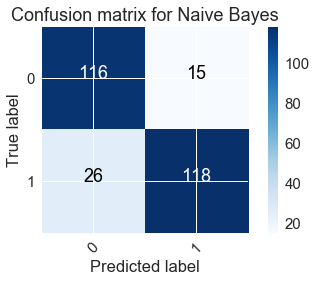

In [627]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix for Naive Bayes')

We can see that there are 26 test examples with "1" sentiment which model classified as "0" sentiment and 15 examples with "0" sentiment which model classified as "1" label.

### Prediction with LSTM

We will try now to use Long Short Term Memory neural network to improve the performance of our initial model. Firstly, we need to tokenize our sentences using Keras' Tokenizer. Also, we st num_words to 2000. This means that the tokenizer detects the 2000 most frequent words from the dataset and use them as features for further model building.

In [628]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['Sentence'].values)
X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X)

Here we build our model. First, we initialize the sequence model. Then, we add word embedding layer, lstm layer with 16 units and the fully connected (dense) layer with 1 (output) neuron with the sigmoid activation function. We use binary_crossentropy loss and [Adam optimizer](https://arxiv.org/abs/1412.6980) to train the model. Also, we set accuracy as the metric for measuring model's performance. You can see the summary of the model in the output of the next cell.

In [629]:
embed_dim = 64
lstm_out = 16

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 1191, 64)          128000    
_________________________________________________________________
lstm_29 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 17        
Total params: 133,201
Trainable params: 133,201
Non-trainable params: 0
_________________________________________________________________
None


Get the target label in the separate variable:

In [630]:
Y = df['Sentiment'].values

Split the dataset into the train and test parts:

In [639]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2473, 1191) (2473,)
(275, 1191) (275,)


In the next cell, we trigger the training of the LSTM neural network. We use batch_size=16 and train the network for 5 epochs. The performance of the model is measured on the validation dataset. Also, we use an early stopping callback if the result doesn't improve during 3 training iterations (epochs). 

In [640]:
batch_size = 16
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, validation_data=(X_test, Y_test),
         callbacks = [EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2, verbose=1)])

Train on 2473 samples, validate on 275 samples
Epoch 1/5
2473/2473 [==============================] - 97s 39ms/step - loss: 0.1516 - acc: 0.9531 - val_loss: 0.1276 - val_acc: 0.9564
Epoch 2/5
2473/2473 [==============================] - 100s 40ms/step - loss: 0.1183 - acc: 0.9664 - val_loss: 0.1317 - val_acc: 0.9527
Epoch 3/5
2473/2473 [==============================] - 103s 42ms/step - loss: 0.0972 - acc: 0.9741 - val_loss: 0.1324 - val_acc: 0.9491
Epoch 00003: early stopping


Now we use our LSTM model to predict the labels for the test set. LSTM model produced the answers as probabilities of classes. So, we use the threshold 0.5 to transform probabilities of classes into class labels. You can see the accuracy of the LSTM neural network in the third cell.

In [641]:
predictions_nn = model.predict(X_test)

In [642]:
for i in range(len(predictions_nn)):
    if predictions_nn[i][0] < 0.5:
        predictions_nn[i][0] = 0
    else:
        predictions_nn[i][0] = 1

In [643]:
print(accuracy_score(Y_test, predictions_nn))

0.949090909091


## Conclusion

In this notebook, we trained the Long Short Term Memory Neural Network as well as Multinomial Naive Bayes Classifier using UCI Sentiment Labelled Sentences Data Set. These models can be used to predict sentiment analysis of the users' reviews. The performance of the models is quite good. Both models give 80-85% accuracy on average.

*Tags: sentiment analysis, natural language processing, neural networks, machine learning, LSTM, RNN*